In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

In [2]:
# load pretrained resnet18
resnet18 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
vgg19 = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
squeezeNet = torch.hub.load('pytorch/vision:v0.6.0', 'squeezenet1_1', pretrained=True)

Using cache found in /home/venom/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/venom/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/venom/.cache/torch/hub/pytorch_vision_v0.6.0


In [3]:
# create dataloader for cifar10

# set random seed
torch.manual_seed(0)

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# fine tune resnet18
resnet18.fc = nn.Linear(512, 10)

# fine tune vgg19
vgg19.classifier[6] = nn.Linear(4096, 10)

# fine tune squeezeNet
squeezeNet.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))

In [5]:
resnet18 = resnet18.cuda()

In [6]:
# define loss function and optimizer
from tqdm import tqdm
import torch.optim as optim

def train(model, epochs, lr):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader)):
      inputs, labels = data
      inputs, labels = inputs.cuda(), labels.cuda()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print('Finished Training')
  print('Loss: ', running_loss/len(trainloader))

def test(model):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      outputs = nn.Softmax(dim=1)(outputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [7]:
train(resnet18, 1, 0.001)
test(resnet18)

# Store test outputs in a dataframe and display the head
predicted = torch.tensor([])
output_probs = torch.tensor([])
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = resnet18(images)
        outputs = nn.Softmax(dim=1)(outputs)
        _, predicted_new = torch.max(outputs.data, 1)
        predicted_new = predicted_new.cpu()
        predicted = torch.cat((predicted, predicted_new), 0)
        output_probs = torch.cat((output_probs, outputs.data.cpu()), 0)
resnet18_test_outputs = pd.DataFrame({'resnet18': predicted.cpu().numpy()})
resnet18_test_probs = pd.DataFrame(output_probs.cpu().numpy())


782it [00:24, 32.04it/s]

Finished Training
Loss:  1.0337642387051107


Accuracy of the network on the 10000 test images: 72 %


In [8]:
resnet18_test_probs.head()

,0,1,2,3,4,5,6,7,8,9
0,0.023770,0.005497,0.015899,0.460435,3.374592e-03,0.471610,6.796948e-03,5.692176e-03,0.005123,0.001803
1,0.000194,0.020092,0.000001,0.000003,8.207907e-07,0.000001,1.754009e-07,2.857265e-07,0.979440,0.000267
2,0.018424,0.057183,0.003791,0.004142,1.413070e-02,0.001529,7.391211e-04,1.526912e-03,0.878848,0.019686
3,0.089871,0.000308,0.001351,0.000119,5.264349e-04,0.000065,3.043739e-05,1.334778e-05,0.902089,0.005628
4,0.001344,0.000030,0.328106,0.042996,1.932166e-01,0.005838,4.283786e-01,3.554900e-05,0.000053,0.000003


In [9]:
resnet18 = resnet18.cpu()
vgg19 = vgg19.cuda()

In [10]:
train(vgg19, 1, 0.001)
test(vgg19)

# Store test outputs in a dataframe and display the head
predicted = torch.tensor([])
output_probs = torch.tensor([])

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = vgg19(images)
        outputs = nn.Softmax(dim=1)(outputs)
        _, predicted_new = torch.max(outputs.data, 1)
        predicted_new = predicted_new.cpu()
        predicted = torch.cat((predicted, predicted_new), 0)
        output_probs = torch.cat((output_probs, outputs.data.cpu()), 0)
vgg19_test_outputs = pd.DataFrame({'vgg19': predicted.cpu().numpy()})
vgg19_test_probs = pd.DataFrame(output_probs.cpu().numpy())

782it [00:50, 15.49it/s]

Finished Training
Loss:  0.7319351405362644


Accuracy of the network on the 10000 test images: 81 %


In [11]:
vgg19 = vgg19.cpu()
squeezeNet = squeezeNet.cuda()

In [12]:
train(squeezeNet, 1, 0.001)
test(squeezeNet)

# Store test outputs in a dataframe and display the head
predicted = torch.tensor([])
output_probs = torch.tensor([])
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = squeezeNet(images)
        outputs = nn.Softmax(dim=1)(outputs)
        _, predicted_new = torch.max(outputs.data, 1)
        predicted_new = predicted_new.cpu()
        predicted = torch.cat((predicted, predicted_new), 0)
        output_probs = torch.cat((output_probs, outputs.data.cpu()), 0)
squeezeNet_test_outputs = pd.DataFrame({'squeezeNet': predicted.cpu().numpy()})
squeezeNet_test_probs = pd.DataFrame(output_probs.cpu().numpy())

782it [00:23, 33.89it/s]

Finished Training
Loss:  2.278032571610892


Accuracy of the network on the 10000 test images: 24 %


In [13]:
squeezeNet = squeezeNet.cpu()
# clear memory
torch.cuda.empty_cache()


In [ ]:
# get corrent labes from testset
correct_labels = []
for data in testloader:
    images, labels = data
    correct_labels.append(labels)
correct_labels = torch.cat(correct_labels, 0)
correct_labels = correct_labels.numpy()


In [14]:
# concatenate test outputs
test_outputs = pd.concat([resnet18_test_outputs, vgg19_test_outputs, squeezeNet_test_outputs], axis=1)
test_outputs

,resnet18,vgg19,squeezeNet
0,5.0,3.0,5.0
1,8.0,8.0,8.0
2,8.0,8.0,8.0
3,8.0,8.0,0.0
4,6.0,6.0,0.0
...,...,...,...
9995,8.0,0.0,2.0
9996,6.0,5.0,2.0
9997,5.0,5.0,5.0
9998,6.0,1.0,2.0


In [15]:
# ensembling
out = test_outputs.mode(axis=1)[0]

In [17]:
# calculate accuracy
from sklearn.metrics import accuracy_score
accuracy_score(out, correct_labels)


0.7477

In [3]:
import torchvision

In [4]:
SEED = 10
DATA = "/home/venom/repo/SKNets/COVID-19_Radiography_Dataset/Balanced"
IMAGE_SIZE = 224
test_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(
    root=DATA, transform=test_data_transform)


In [6]:
dataset.class_to_idx

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [24]:
confidece_fusion_test_probs = (resnet18_test_probs + vgg19_test_probs + squeezeNet_test_probs)
confidece_fusion_test_probs

,0,1,2,3,4,5,6,7,8,9
0,0.124167,0.120745,0.117589,1.113703,0.109166,0.936213,0.139384,0.110271,0.105393,0.123369
1,0.278851,0.152909,0.034902,0.034888,0.034889,0.034887,0.034887,0.034888,2.294150,0.064749
2,0.172664,0.162809,0.004956,0.005137,0.015163,0.002532,0.001726,0.002560,2.607812,0.024639
3,0.530715,0.099280,0.107473,0.059500,0.060376,0.057467,0.078803,0.072861,1.866373,0.067152
4,0.171081,0.086800,0.478439,0.131948,0.280933,0.092694,1.497661,0.086810,0.086860,0.086773
...,...,...,...,...,...,...,...,...,...,...
9995,0.887408,0.055100,0.570798,0.102430,0.058149,0.072471,0.155854,0.089245,0.967610,0.040935
9996,0.073718,0.073168,0.201465,0.312775,0.228211,0.729738,1.120230,0.113193,0.073718,0.073783
9997,0.061303,0.061295,0.076378,0.076486,0.062482,2.408776,0.062036,0.068567,0.061322,0.061356
9998,0.511063,0.994869,0.519807,0.121730,0.130356,0.079461,0.368247,0.122980,0.074504,0.076983


In [ ]:
confidece_fusion_test_probs_tensor = torch.tensor(confidece_fusion_test_probs.values)
# get the class form confidece_fusion_test_probs with the highest probability
out_conf = torch.argmax(confidece_fusion_test_probs_tensor, dim=1)
out_conf = out_conf.cpu().numpy()

In [35]:
accuracy_score(out_conf, correct_labels)

0.8208

In [7]:
import numpy as np

In [8]:
array = np.array([[147,   6,   4,   1],
       [  0, 129,   4,   0],
       [  1,   1, 118,   4],
       [  4,   2,   3, 126]])

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [20]:
plt.rcParams.update({'font.size': 22})

<AxesSubplot:>

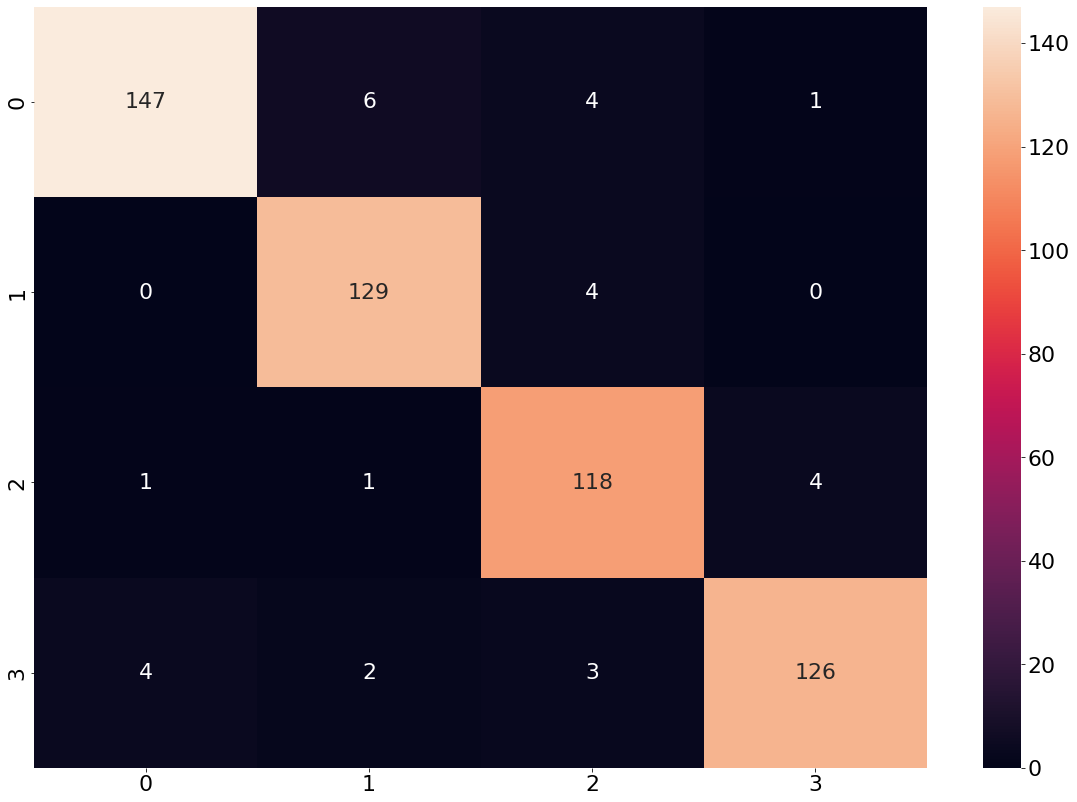

In [9]:
plt.figure(figsize=(20,14))
sns.heatmap(array, annot=True, fmt='d')

In [9]:
conf = np.array([[146,   4,   4,   0],
       [  0, 131,   4,   0],
       [  2,   1, 118,   4],
       [  4,   2,   3, 127]])

In [12]:
cls2idx = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [13]:
df = pd.DataFrame(conf, index=[
                  'COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'], columns=['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'])


In [14]:
df

,COVID,Lung_Opacity,Normal,Viral Pneumonia
COVID,146,4,4,0
Lung_Opacity,0,131,4,0
Normal,2,1,118,4
Viral Pneumonia,4,2,3,127


<AxesSubplot:>

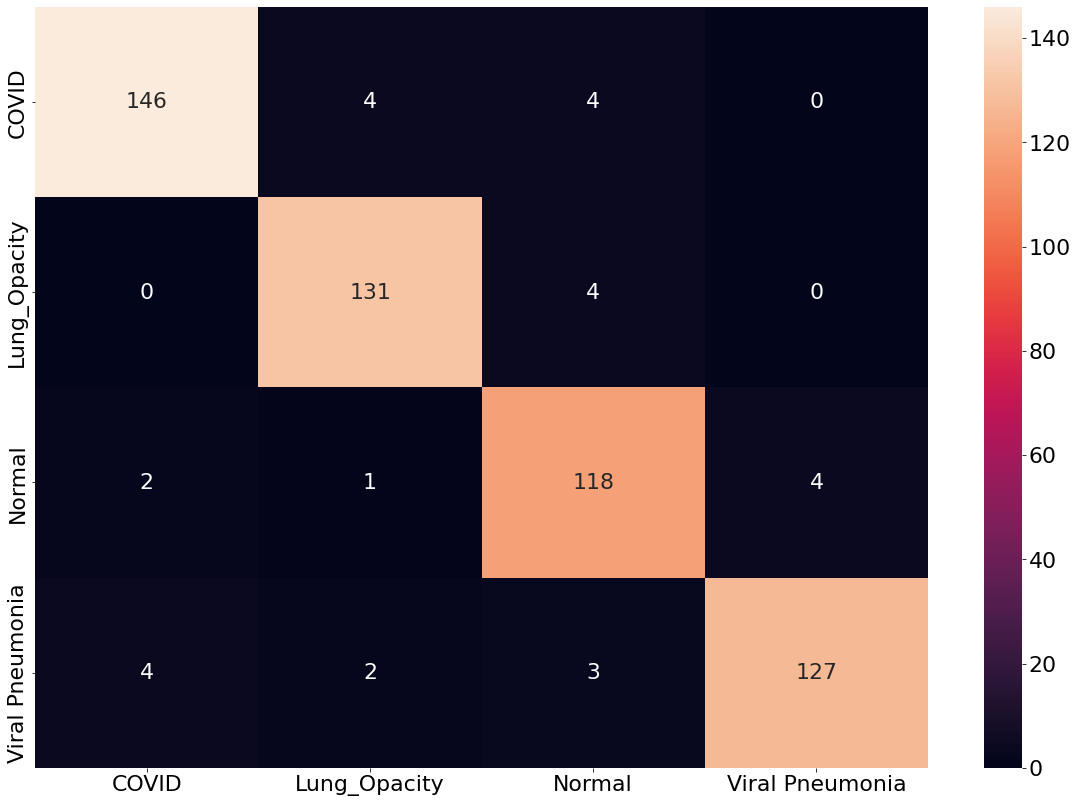

In [21]:
plt.figure(figsize=(20,14))
sns.heatmap(df, annot=True, fmt='d')